In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

silent_volts_path = '/content/yaro_silent_4_volts.csv'
silent_labels_path = '/content/yaro_silent_4_labels.csv'

silent_volts_df = pd.read_csv(silent_volts_path).iloc[:, :6]    # Only take the first 6 columns
silent_labels_df = pd.read_csv(silent_labels_path, header=None)
print(len(silent_labels_df))

50


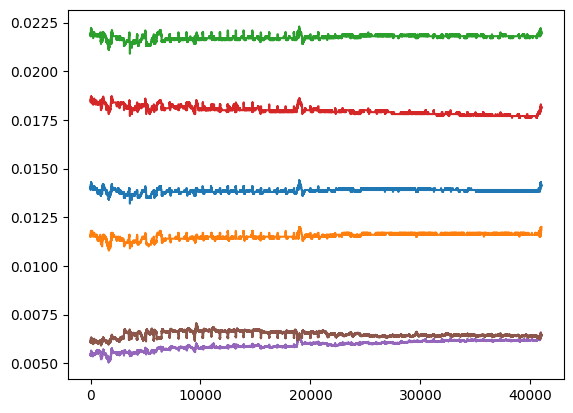

In [54]:
plt.plot(silent_volts_df);

In [58]:
# YARO preproccessing
from scipy.signal import butter, filtfilt, iirnotch

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def apply_notch_filter(data, notch_freq, fs, quality_factor=30):
    b, a = iirnotch(notch_freq / (0.5 * fs), quality_factor)
    y = filtfilt(b, a, data)
    return y

# Parameters for the filters
fs = 250  # Sampling rate in Hz
lowcut = 1.3  # Low cut frequency in Hz
highcut = 50  # High cut frequency in Hz, adjusted for movement artifact avoidance
notch_freq = 60  # Notch frequency for power line noise in Hz

silent_volts_df_yaro_processed = silent_volts_df.copy()

# Apply the Butterworth bandpass filter
for column in silent_volts_df_yaro_processed.columns:
    silent_volts_df_yaro_processed[column] = butter_bandpass_filter(silent_volts_df_yaro_processed[column].values, lowcut, highcut, fs, order=4)

# Apply the notch filter
for column in silent_volts_df_yaro_processed.columns:
    silent_volts_df_yaro_processed[column] = apply_notch_filter(silent_volts_df_yaro_processed[column].values, notch_freq, fs)

silent_volts_df_yaro_processed = silent_volts_df_yaro_processed.to_numpy()

In [52]:
import numpy as np
import scipy.signal as signal

def preprocess_signals_gpt(signals):
    # Normalizing by initial values
    initial_values = signals[0, :][np.newaxis, :]
    signals /= initial_values

    # Centering signals around zero mean
    signals -= signals.mean(axis=0, keepdims=True)

    # High-pass filter to remove low frequency drifts
    highpass_cutoff = 0.5  # Frequency in Hz
    fs = 250  # Sampling rate of 250 Hz
    b, a = signal.butter(1, highpass_cutoff / (fs / 2), btype='high')  # Normalized frequency
    signals = signal.filtfilt(b, a, signals, axis=0)


    # Notch filter at 60 Hz and its harmonics
    for harmonic in [60, 120]:  # Assuming 120 Hz is below Nyquist frequency for your sampling rate
        b, a = signal.iirnotch(harmonic / (fs / 2), Q=30)  # Normalized frequency, Q is the quality factor
        signals = signal.filtfilt(b, a, signals, axis=0)

    # Ricker wavelet convolution for heartbeat artifact removal
    widths = np.arange(1, 10)
    # Applying CWT individually for each signal
    for i in range(signals.shape[1]):  # Loop over channels
        signal_1d = signals[:, i]
        cwtmatr = signal.cwt(signal_1d, signal.ricker, widths)
        # Subtracting the mean of the wavelet-transformed signal from the original signal
        signals[:, i] -= cwtmatr.mean(axis=0)

    # Band-pass filter to allow frequencies from 0.5 to 8 Hz
    bandpass_lowcut = 0.5
    bandpass_highcut = 8
    b, a = signal.butter(1, [bandpass_lowcut / (fs / 2), bandpass_highcut / (fs / 2)], btype='band')
    signals = signal.filtfilt(b, a, signals, axis=0)

    return signals

# Use with your signals data, assuming silent_volts_df.to_numpy() is your signals
preprocessed_signals = silent_volts_df.to_numpy().copy()
preprocessed_signals = preprocess_signals_gpt(preprocessed_signals)

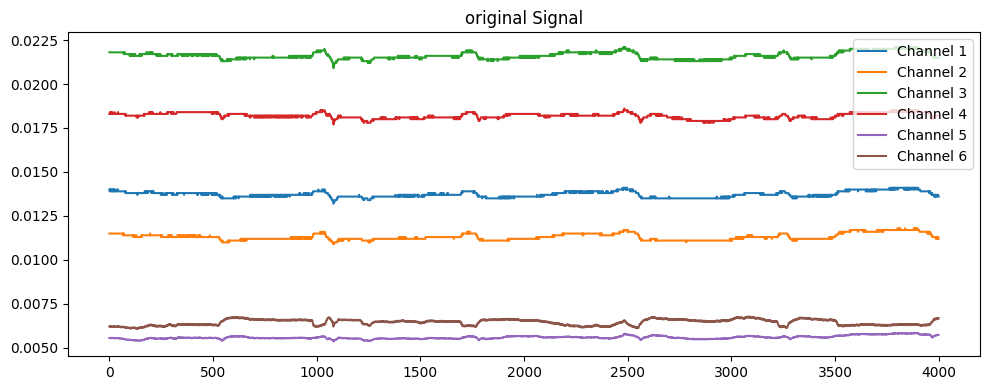

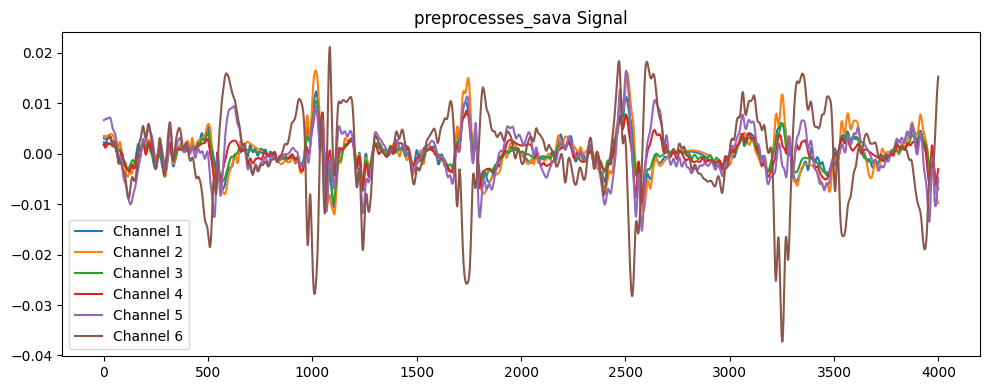

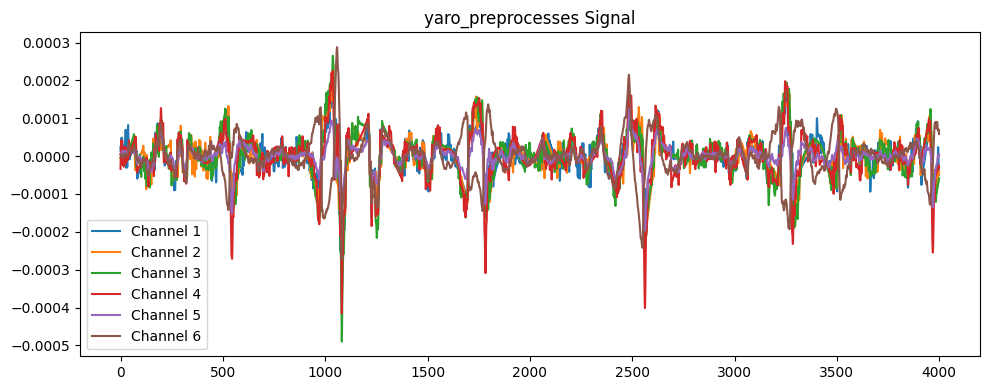

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signals, start_sample=2500, end_sample=2500+250*3, signal_label=''):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = signals.shape[1]
    for channel in range(num_channels):
        ax.plot(signals[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title(f'{signal_label} Signal')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_signal(silent_volts_df.to_numpy(), 2500, 2500+250*16, 'original')
plot_signal(preprocessed_signals, 2500, 2500+250*16, 'preprocesses_sava') # this one is the best so fat but should be also improved
plot_signal(silent_volts_df_yaro_processed, 2500, 2500+250*16, 'yaro_preprocesses')

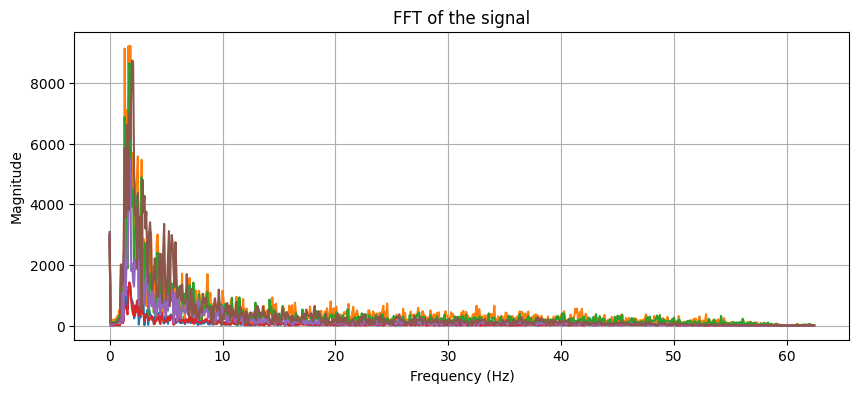

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# # Sample rate and duration
fs = 250  # Sampling frequency in Hz

# Plotting the FFT
plt.figure(figsize=(10, 4))
for i in range(6):
  #y = preprocessed_signals[2500:2500+250*12,i]
  #y = silent_volts_df.to_numpy()[2500:2500+250*12,i]
  y = silent_volts_df_yaro_processed[2500:2500+250*12,i]
  y = y/y[0]-1
  # Compute the FFT
  y_fft = np.fft.fft(y)
  frequencies = np.fft.fftfreq(y.size, 1/fs)

  # Since the FFT output is symmetric, we only need to plot the first half for real signals
  n = y.size // 4  # Half of the signal length
  plt.plot(frequencies[:n], np.abs(y_fft[:n]))  # Plot magnitude spectrum

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of the signal')
plt.grid(True)
plt.show()

# now matching signal with labels and training the model

In [96]:
import numpy as np
import pandas as pd

# Assuming voiced_labels_df is loaded and contains binary labels ('yes'/'no' converted to 1/0)
voiced_binary_labels = silent_labels_df.iloc[:, 0].map({'yes': 1, 'no': 0}).tolist()
print(f"Total number of labels: {len(voiced_binary_labels)}")

# Function to chunk the multichannel voltage signals into 5-second chunks with a 2.5 second offset
def chunk_signals_from_offset_multichannel(preprocessed_signals, chunk_size=750, offset=2500):
    chunks = []
    # Calculate the number of rows to skip at the start based on the offset
    start_index = offset
    # Calculate the number of chunks possible with the given offset and chunk size
    for i in range(start_index, len(preprocessed_signals), chunk_size):
        # Ensure the chunk does not exceed the dataframe's length
        if i + chunk_size <= len(preprocessed_signals):
            chunk = preprocessed_signals[i:i + chunk_size]  # This keeps the chunk in a multichannel format
            chunks.append(chunk)
    return chunks

# Use the adjusted chunking function for multichannel data
silent_volts_chunks = chunk_signals_from_offset_multichannel(preprocessed_signals)
print(f"Total number of chunks before aligning: {len(silent_volts_chunks)}")

# Since each chunk now is a 2D array (1250x8), we need to adjust how we align and handle these with labels.
# Align the chunks with the binary labels
min_length = min(len(silent_volts_chunks), len(voiced_binary_labels))
silent_volts_chunks_aligned = silent_volts_chunks[:min_length]
silent_binary_labels_aligned = voiced_binary_labels[:min_length]

Total number of labels: 50
Total number of chunks before aligning: 51


In [97]:
# Print lengths to verify alignment
print(f'Number of aligned chunks: {len(silent_volts_chunks_aligned)}')
print(f'Number of aligned labels: {len(silent_binary_labels_aligned)}')

# Verify that the lengths match
if len(silent_volts_chunks_aligned) == len(silent_binary_labels_aligned):
    print("The number of chunks and labels are correctly aligned.")
else:
    print("Mismatch in the number of chunks and labels.")

# Inspect first aligned chunk
if silent_volts_chunks_aligned:  # Check if there's at least one chunk
    example_chunk = np.array(silent_volts_chunks_aligned[0])
    # Append the binary label to the last column of the chunk
    label_for_chunk = silent_binary_labels_aligned[0]
    print(f"Example chunk shape (before label): {example_chunk.shape}")
    print(f"Label for example chunk: {label_for_chunk}")
else:
    print("No chunks available for demonstration.")

Number of aligned chunks: 50
Number of aligned labels: 50
The number of chunks and labels are correctly aligned.
Example chunk shape (before label): (750, 6)
Label for example chunk: 0


In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Flatten each chunk for use in a fully connected neural network
X = np.array([chunk.flatten() for chunk in silent_volts_chunks_aligned])

# For CNN dont flatten
#X = np.array([chunk for chunk in silent_volts_chunks_aligned])
#X = X.transpose(0, 2, 1)

y = np.array(silent_binary_labels_aligned)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert data to torch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # add an extra dimension to y
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)  # add an extra dimension to y

# Create tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

In [132]:
X_train.shape

(25, 4500)

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Assuming the input dimension is (batch_size, channels, height, width)
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=400, kernel_size=12)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=6)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=3)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=3)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=3)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate the size of the flattened features after the last pooling layer
        self._to_linear = None
        self.convs = nn.Sequential(self.conv1, nn.ReLU(), self.pool1,
                                   self.conv2, nn.ReLU(), self.pool2,
                                   self.conv3, nn.ReLU(), self.pool3,
                                   self.conv4, nn.ReLU(), self.pool4,
                                   self.conv5, nn.ReLU(), self.pool5)
        self._get_conv_output((6, 750))  # Example size

        self.fc1 = nn.Linear(self._to_linear, 250)  # The size will depend on the final pooling layer output
        self.drop1 = nn.Dropout(p=0.7)
        self.fc2 = nn.Linear(250, 1)
        self.drop2 = nn.Dropout(p=0.5)

    def _get_conv_output(self, shape):
        # Determine the size of the features after the conv and pooling layers
        with torch.no_grad():
            input = torch.rand(1, *shape)
            output = self.convs(input)
            self._to_linear = output.data.view(1, -1).size(1)

    def forward(self, x):
        # Pass the input through the conv layers
        x = self.convs(x)

        # Flatten the output for the dense layers
        x = x.view(-1, self._to_linear)

        # Pass the output through the dense layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)

        # Softmax activation for the output
        x = torch.sigmoid(x)
        #x = F.log_softmax(x, dim=1)
        return x


class SimpleFNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Model initialization
input_size = X_train.shape[1]  # Number of features
model = SimpleFNN(input_size).to(device)
#model = CustomCNN().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 0.0001

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



    # Evaluating the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.round()  # Using 0.5 as the threshold
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, BCELoss Train: {loss.item()}', f'Accuracy Test: {accuracy}%') # Looks too good - try to interpret somehow

cuda
Epoch 1/10, BCELoss Train: 0.7408674955368042 Accuracy Test: 48.0%
Epoch 2/10, BCELoss Train: 0.6852496266365051 Accuracy Test: 88.0%
Epoch 3/10, BCELoss Train: 0.630778968334198 Accuracy Test: 92.0%
Epoch 4/10, BCELoss Train: 0.5585595369338989 Accuracy Test: 92.0%
Epoch 5/10, BCELoss Train: 0.0003600997442845255 Accuracy Test: 92.0%
Epoch 6/10, BCELoss Train: 0.33255457878112793 Accuracy Test: 92.0%
Epoch 7/10, BCELoss Train: 0.17469890415668488 Accuracy Test: 92.0%
Epoch 8/10, BCELoss Train: 3.1551786605632515e-07 Accuracy Test: 96.0%
Epoch 9/10, BCELoss Train: 0.0349067747592926 Accuracy Test: 96.0%
Epoch 10/10, BCELoss Train: 0.0070533365942537785 Accuracy Test: 96.0%


In [134]:
model

SimpleFNN(
  (fc1): Linear(in_features=4500, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
import torch
from safetensors.torch import save_file

# Assuming 'model' is your trained model
model_path = "SimpleFNN_1229.st"  # Use .st extension for SafeTensors

# Save model's state_dict with SafeTensors
state_dict = model.state_dict()
save_file(state_dict, model_path)

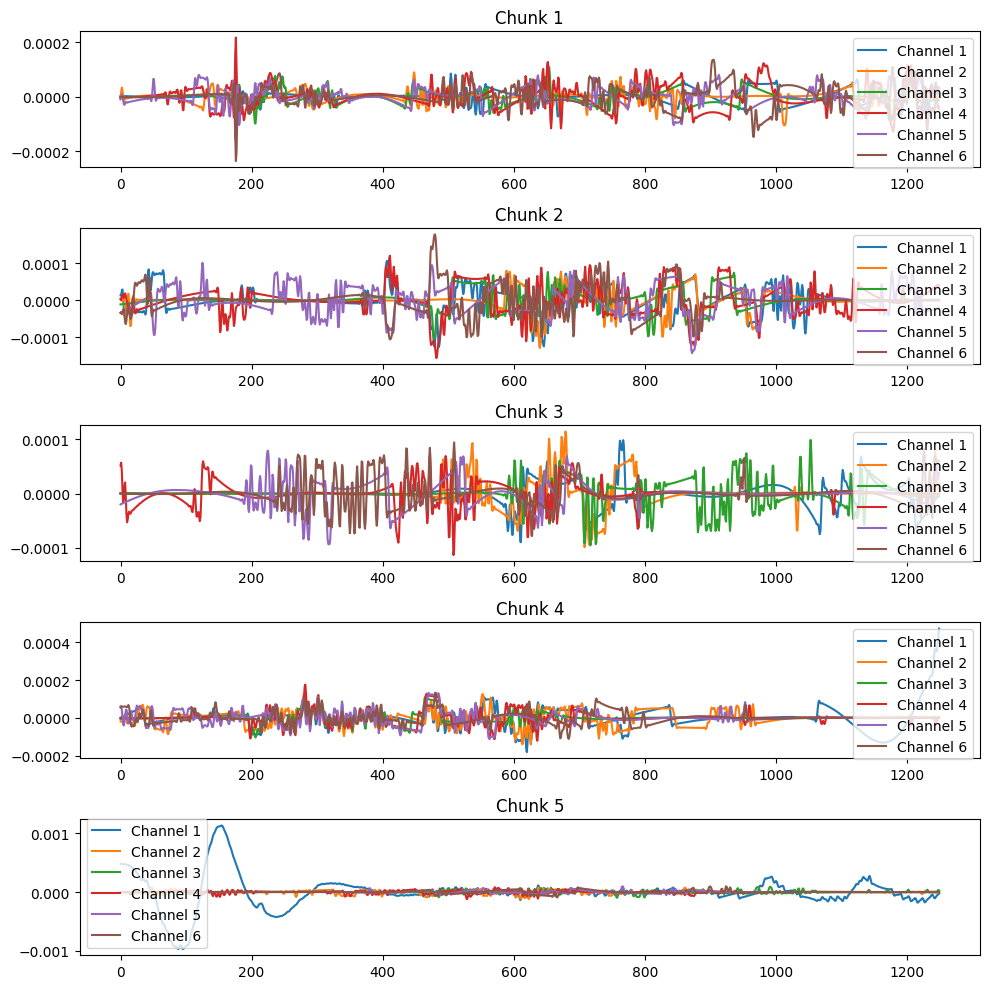

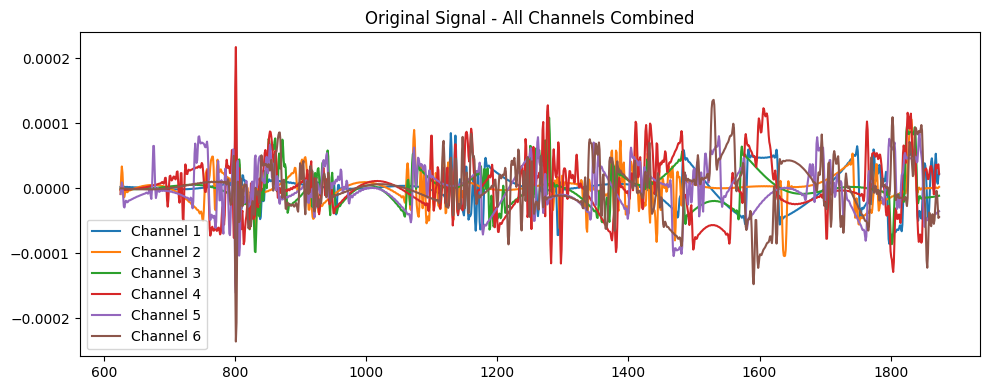

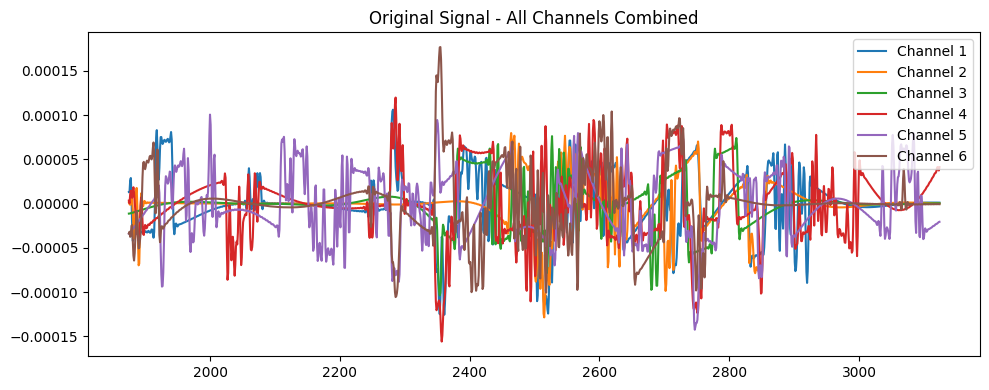

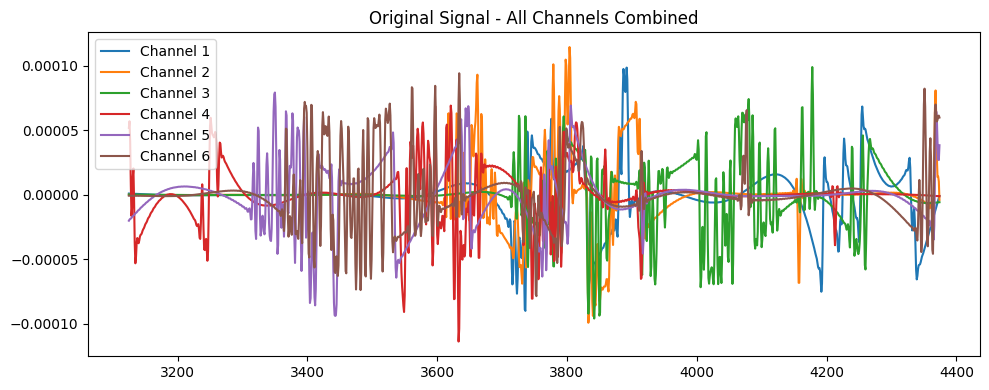

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal_chunks_combined(chunks, num_chunks=5):
    """
    Plots combined channels for each signal chunk.
    """
    fig, axs = plt.subplots(num_chunks, 1, figsize=(10, 2 * num_chunks), squeeze=False)
    for i, chunk in enumerate(chunks[:num_chunks]):
        for channel in range(chunk.shape[1]):
            axs[i, 0].plot(chunk[:, channel], label=f'Channel {channel+1}')
        axs[i, 0].set_title(f'Chunk {i+1}')
        axs[i, 0].legend()
    plt.tight_layout()
    plt.show()

def plot_original_signal_combined(df, start_sample=625, end_sample=1875):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = df.shape[1]
    for channel in range(num_channels):
        ax.plot(df.iloc[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title('Original Signal - All Channels Combined')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_signal_chunks_combined(voiced_volts_chunks, num_chunks=5)
plot_original_signal_combined(voiced_volts_df, 625, 1875)
plot_original_signal_combined(voiced_volts_df, 1875, 3125)
plot_original_signal_combined(voiced_volts_df, 3125, 4375)

## plot all yesses an nos averaged

In [ ]:
import numpy as np

def smooth_array(array, window_size=5):
    """
    Smooths each row of a 2D array using a moving average filter.

    Parameters:
    - array: 2D numpy array of shape (6, 1250)
    - window_size: The size of the moving window for the moving average filter

    Returns:
    - smoothed_array: 2D numpy array of shape (6, 1250) after smoothing
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if window_size > array.shape[0]:
        raise ValueError("Window size larger than array dimension.")

    # Define the filter: simple moving average
    filter_kernel = np.ones(window_size) / window_size

    # Apply the filter along the second axis for each row
    smoothed_array = np.apply_along_axis(lambda m: np.convolve(m, filter_kernel, mode='same'), axis=0, arr=array)

    return smoothed_array

In [ ]:
yeses = []
nos = []
for label, chunk  in zip(voiced_binary_labels_aligned, voiced_volts_chunks_aligned):
  if label == 1:
    yeses.append(smooth_array(chunk, 10))
  else:
    nos.append(smooth_array(chunk, 10))
nos = np.array(nos)
yeses = np.array(yeses)

NameError: name 'nos' is not defined

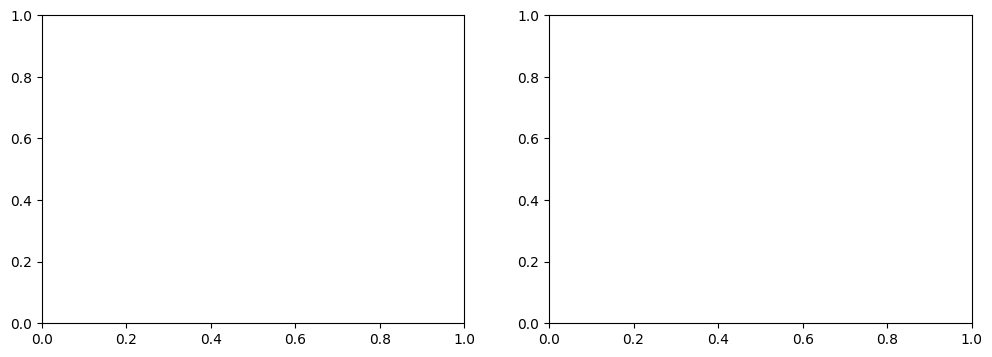

In [27]:
# Plotting YES vs NO smoothened
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(nos[6:].mean(axis = 0));
axs[1].plot(yeses[6:].mean(axis = 0));
axs[0].set_title("'No' Avg, n=52")
axs[1].set_title("'Yes' Avg, n=47")
#for ax in axs:
#    ax.legend()
plt.show()

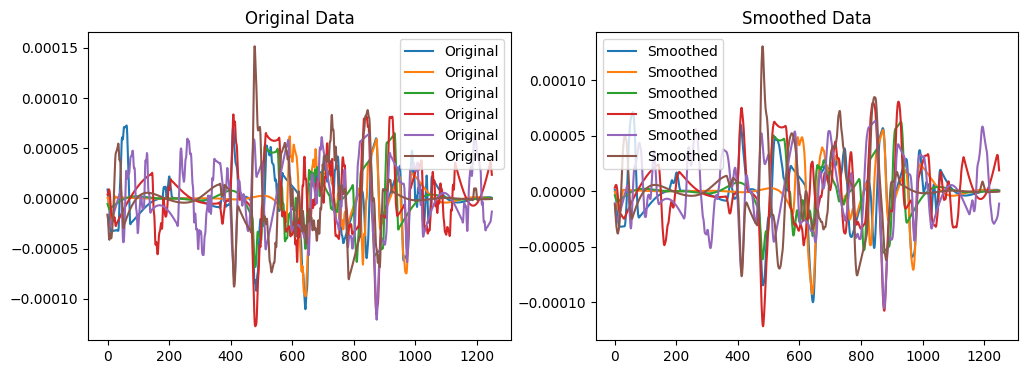

In [ ]:
# Smooth the array
smoothed_nos = smooth_array(nos[0], 10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(nos[0], label='Original')
axs[1].plot(smoothed_nos, label='Smoothed')
axs[0].set_title('Original Data')
axs[1].set_title('Smoothed Data')
for ax in axs:
    ax.legend()
plt.show()

NameError: name 'nos' is not defined

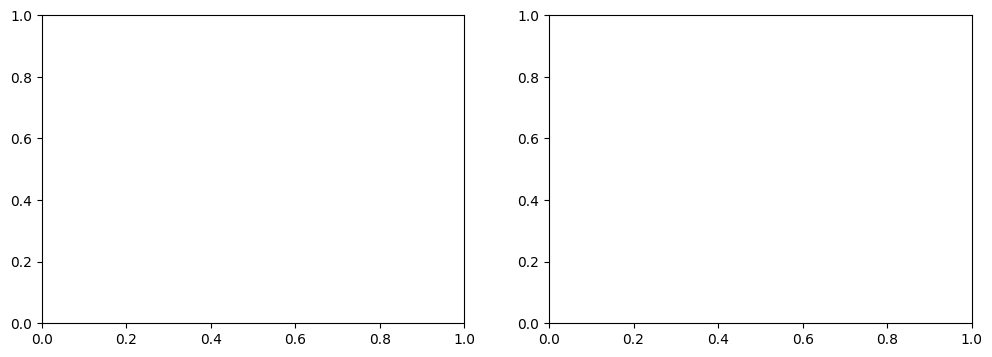

In [26]:
# Plotting YES vs NO smoothened
for sample_n in range(1):
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(nos[sample_n])
  axs[1].plot(yeses[sample_n])
  axs[0].set_title(f'No, sample_n={sample_n}')
  axs[1].set_title(f'Yes, sample_n={sample_n}')
  #for ax in axs:
  #    ax.legend()
  plt.show()